In [1]:
from env import Enviroment
from evolved_agent import EvolvedAgent
from actors import Agent, Wall, Landmark
from typing import List
import numpy as np
from copy import deepcopy
from math import degrees, atan2, pi
from utils import (
    distance_from_wall,
    intersection,
    angle_from_vector,
    intersection_line_circle,
)
import torch
from nn import NN
from parameters import *
import matplotlib.pyplot as plt
from numpy import ceil
import pygame
import math
import matplotlib.animation as animation

CLIP = 50
GRID_SIZE = 10


class EnvEvolution(Enviroment):
    def __init__(
        self,
        agent: EvolvedAgent,
        walls: List[Wall] = [],
        landmarks: List[Landmark] = [],
        height=800,
        width=800,
        instants=1000,
        w1=1,
        w2=1,
        w3=0.2,
    ):
        super().__init__(agent, walls, landmarks)
        self.height = height
        self.width = width
        self.map = np.zeros((self.width, self.height))
        self.collisions = 0
        self.movements = 0
        self.instants = instants
        self.W1 = w1
        self.W2 = w2
        self.W3 = w3
        self.distance = self.agent.max_distance * np.ones(self.instants)
        self.path = []
        self.map = np.zeros((self.width, self.height))
        self.w = []

    def reset(self, random=False):
        if random:
            self.agent.pos = np.array(
                [np.random.randint(0, self.width), np.random.randint(0, self.height)],
                dtype=np.float64,
            )
            self.agent.direction_vector = np.array(
                [np.random.randint(-1, 2), np.random.randint(-1, 2)], dtype=np.float64
            )
        else:
            self.agent.pos = np.array(
                [self.width // 2, self.height // 2], dtype=np.float64
            )
        self.collisions = 0
        self.movements = 0
        self.map = np.zeros((self.width, self.height))
        self.distance = self.agent.max_distance * np.ones(self.instants)
        self.path = []

    def move_agent(self, dt=1):

        x_start, y_start = self.agent.pos
        try:
            distances = np.array(
                [
                    data[1][0]
                    for data in self.get_sensor_data(
                        self.agent.n_sensors, self.agent.max_distance
                    )
                ],
                dtype=np.float32,
            )
            vl, vr = self.agent.controller.forward(
                torch.tensor(distances, dtype=torch.float)
            )
        except Exception as e:
            print(e)
            vl, vr = 0, 0

        vl = vl * 10
        vr = vr * 10
        v, w = (vl + vr) / 2, (vr - vl) / (self.agent.size * 2)
        if w == v == 0:
            return
        
        # print("vl, vr, v, w", vl, vr, v, w)

        # if distances[0] > self.agent.size * 2:
        #     w = 0
        #     if 0 < v < 1:
        #         v = 1
        #     elif -1 < v < 0:
        #         v = -1
        #     elif v > 1:
        #         v *= 10
        #     elif v < -1:
        #         v *= 10

        # if distances[0] < self.agent.size * 2:
        #     v = 0
        #     w *= 10
        dx, dy, dtheta = 0, 0, w * dt
        if w == 0:
            dx = v * dt * np.cos(self.agent.direction)
            dy = v * dt * np.sin(self.agent.direction)
        else:
            R = v / w
            dx = R * (
                np.sin(self.agent.direction + dtheta) - np.sin(self.agent.direction)
            )
            dy = -R * (
                np.cos(self.agent.direction + dtheta) - np.cos(self.agent.direction)
            )

        dx, dy = round(dx), round(dy)
        move_vector = np.array([dx, dy])

        for wall in self.walls:
            current_d = distance_from_wall(wall, self.agent.pos)

            if current_d <= self.agent.size:
                # Vector of the wall direction
                wall_vector = np.array(
                    [wall.end[0] - wall.start[0], wall.end[1] - wall.start[1]]
                )
                wall_vector = wall_vector / np.linalg.norm(wall_vector)

                # Vector of the agent parallel to the wall
                parallel_component = np.dot(wall_vector, move_vector) * wall_vector

                # Vector of the agent perpendicular to the wall
                wall_to_agent = self.agent.pos - np.array(
                    distance_from_wall(wall, self.agent.pos, coords=True)
                )
                wall_to_agent = wall_to_agent / np.linalg.norm(wall_to_agent)

                # If the agent is inside the wall push it out
                self.agent.apply_vector(wall_to_agent * (self.agent.size - current_d))
                # Check if the agent is moving towards the wall
                if np.dot(self.agent.direction_vector, -wall_to_agent) > 0:
                    # If the agent is moving towards the wall only consider the parallel component
                    move_vector = parallel_component

        # Check if the agent is making an illegal move
        for wall in self.walls:
            intersection_point = intersection(
                Wall(
                    self.agent.pos[0],
                    self.agent.pos[1],
                    self.agent.pos[0] + move_vector[0],
                    self.agent.pos[1] + move_vector[1],
                ),
                wall,
            )
            if intersection_point:
                # print("ILLEGAL MOVE")
                return
        self.agent.apply_vector(move_vector)

        # Aggiorna il percorso
        self.path.append((self.agent.pos[0], self.agent.pos[1]))

        # Set visited positions to 1 within -10 to +10 range around agent's position
        x_start = max(0, int(x_start) - 10)
        x_end = min(self.map.shape[0], int(self.agent.pos[0]) + 10 + 1)
        y_start = max(0, int(y_start) - 10)
        y_end = min(self.map.shape[1], int(self.agent.pos[1]) + 10 + 1)

        # Efficiently set the range using numpy slicing
        if x_start > x_end:
            x_start, x_end = x_end, x_start
        if y_start > y_end:
            y_start, y_end = y_end, y_start
        self.map[x_start:x_end, y_start:y_end] = 1

        # Ruota l'agente
        self.agent.rotate(dtheta)

    def fitness_score(self) -> float:
        # mean_angular_velocity = np.mean(np.abs(self.w))
        # print(f"Mean Angular Velocity: {mean_angular_velocity}")
        if self.collisions == 0:
            return self.explored_terrain  # - mean_angular_velocity
        return self.explored_terrain  # + 1 / self.collisions - mean_angular_velocity

    @property
    def explored_terrain(self) -> float:
        return np.sum(self.map) / (self.width * self.height)

    def visualize_movement(self):
        if not self.path:
            return

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(self.map.T, origin="lower", cmap="gray_r")

        # Correct the point size for the agent
        ax.scatter(
            self.agent.pos[0],
            self.agent.pos[1],
            color="green",
            s=(self.agent.size * 2) ** 2,
            label="Agent",
        )

        for wall in self.walls:
            ax.plot(
                [wall.start[0], wall.end[0]],
                [wall.start[1], wall.end[1]],
                "b-",
                linewidth=2,
            )

        # Plot the path
        path = np.array(self.path)
        ax.plot(path[:, 0], path[:, 1], "r-", label="Path")

        ax.set_title("Agent Movement and Explored Terrain")
        ax.set_xlabel("Width")
        ax.set_ylabel("Height")
        ax.legend()
        plt.show()

pygame 2.5.2 (SDL 2.28.3, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


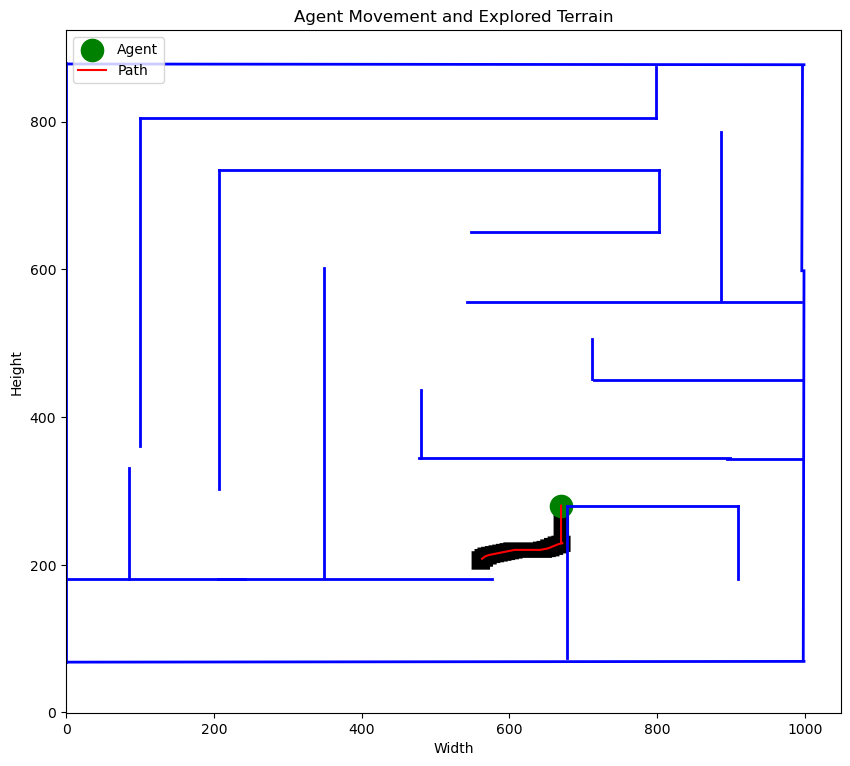

final pos [670. 280.] initial pos [559. 204.]  collisions 0 explored terrain 0.007075 fitness 0.007075


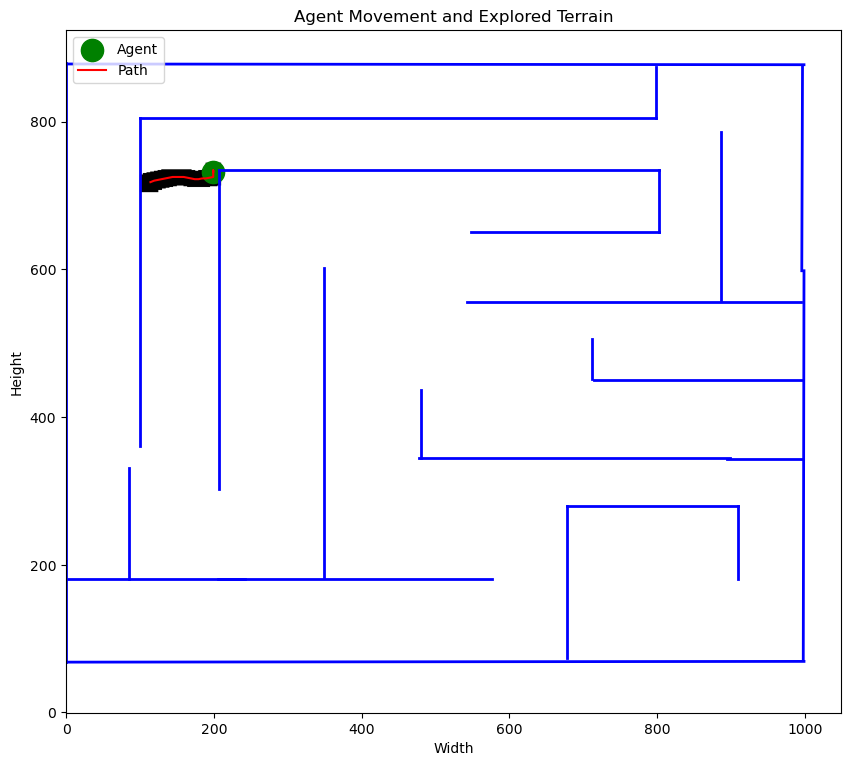

final pos [199. 732.] initial pos [110. 715.]  collisions 0 explored terrain 0.004484375 fitness 0.004484375


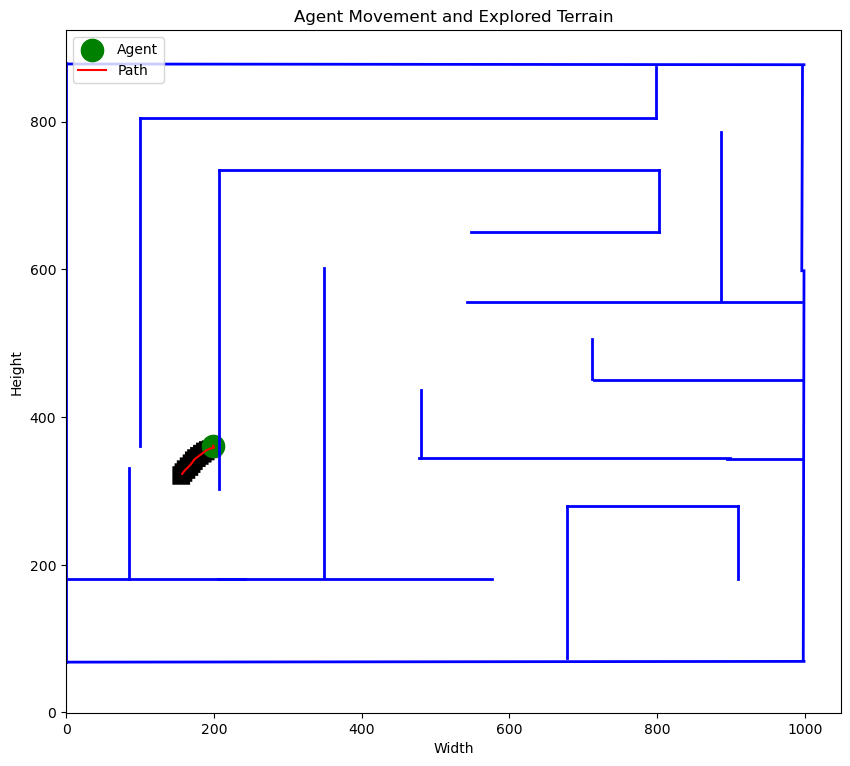

final pos [199. 361.] initial pos [154. 319.]  collisions 0 explored terrain 0.0037640625 fitness 0.0037640625


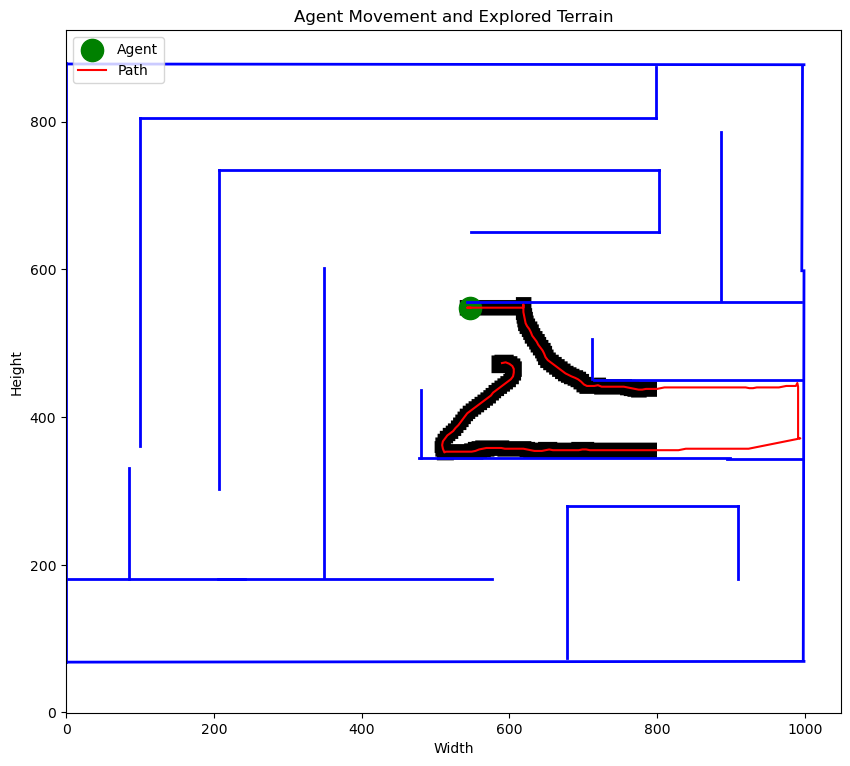

final pos [547. 548.] initial pos [586. 470.]  collisions 0 explored terrain 0.0287015625 fitness 0.0287015625


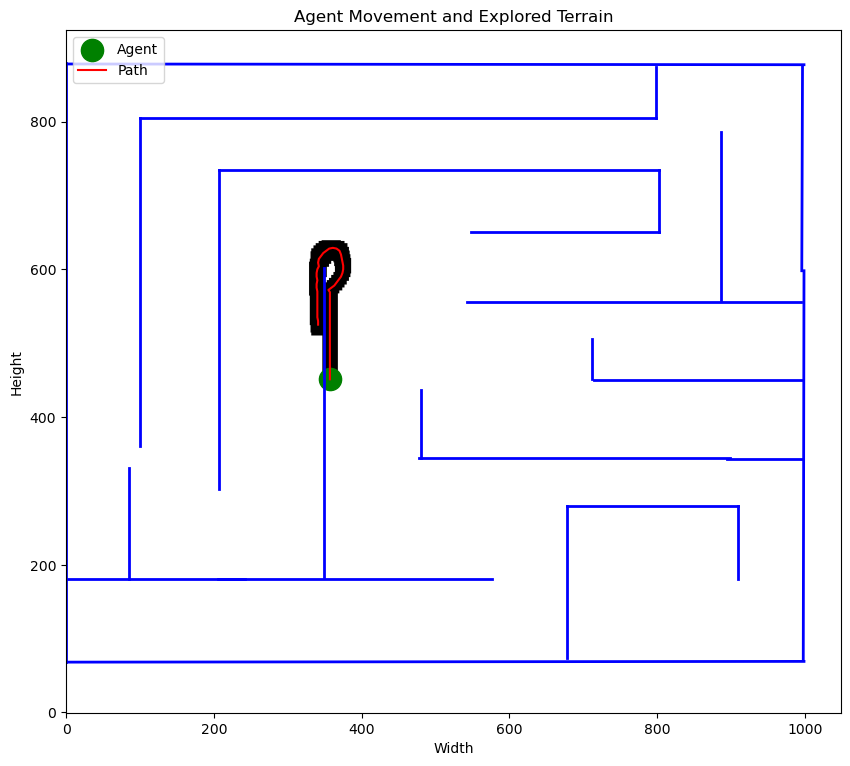

final pos [357. 451.] initial pos [342. 521.]  collisions 0 explored terrain 0.0110046875 fitness 0.0110046875


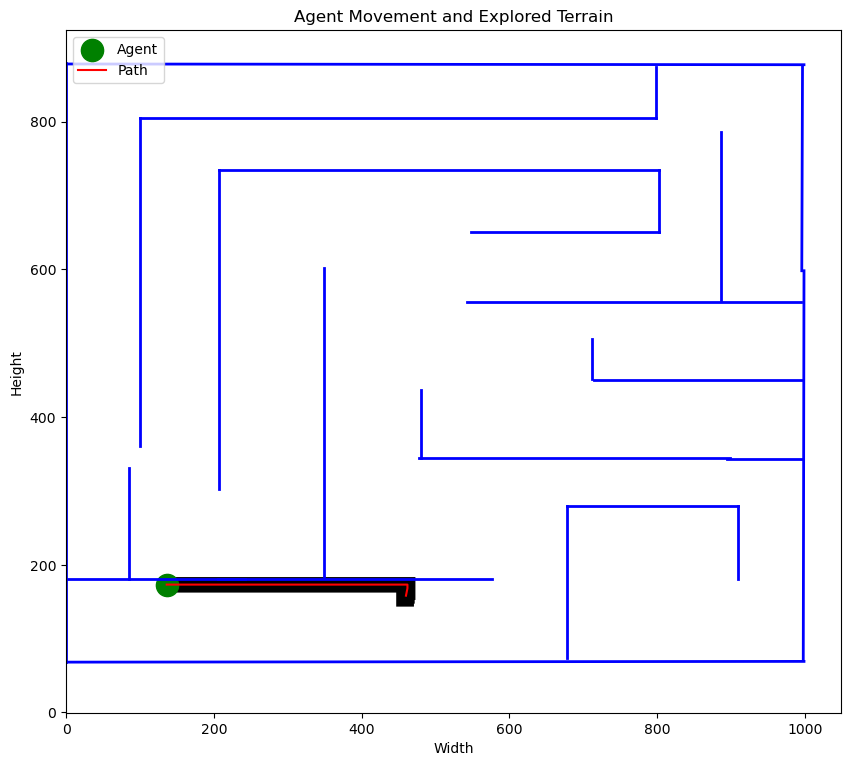

final pos [136. 173.] initial pos [457. 154.]  collisions 0 explored terrain 0.0121375 fitness 0.0121375


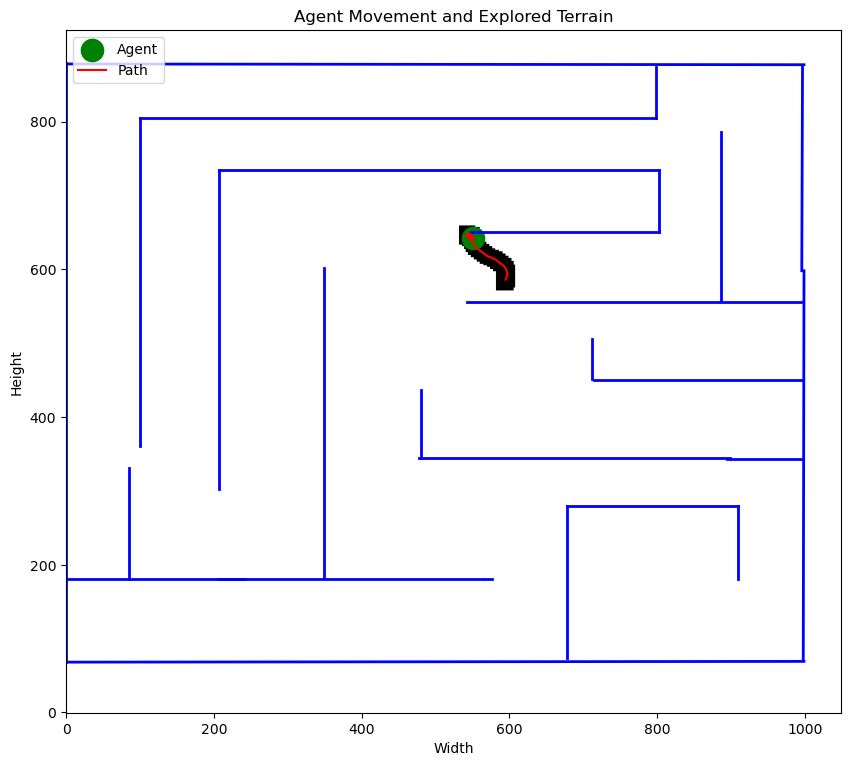

final pos [551. 642.] initial pos [592. 582.]  collisions 0 explored terrain 0.0047078125 fitness 0.0047078125


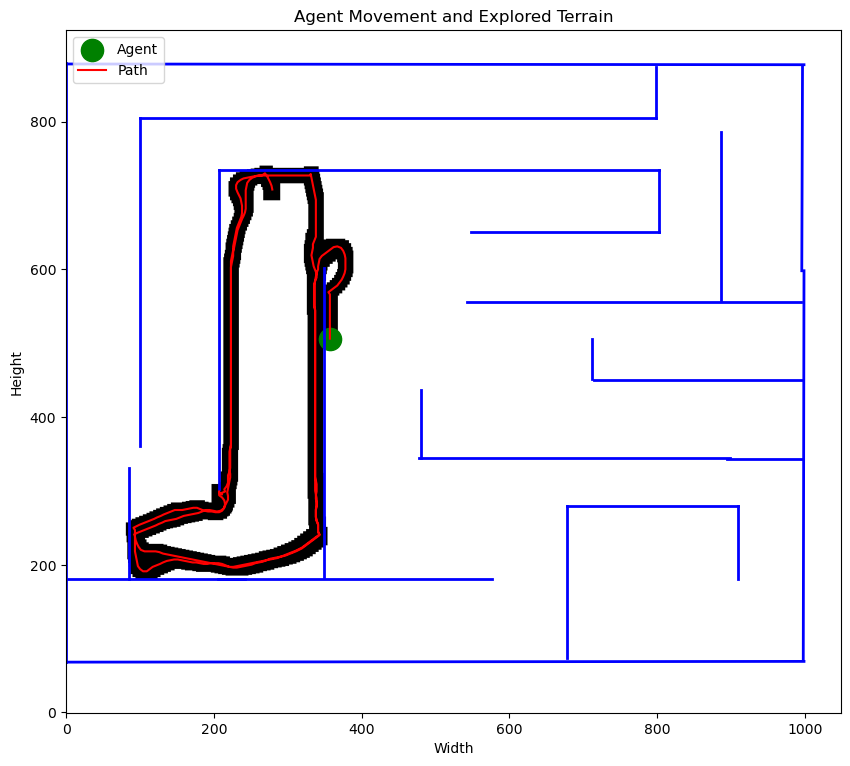

final pos [357. 506.] initial pos [277. 704.]  collisions 0 explored terrain 0.063178125 fitness 0.063178125


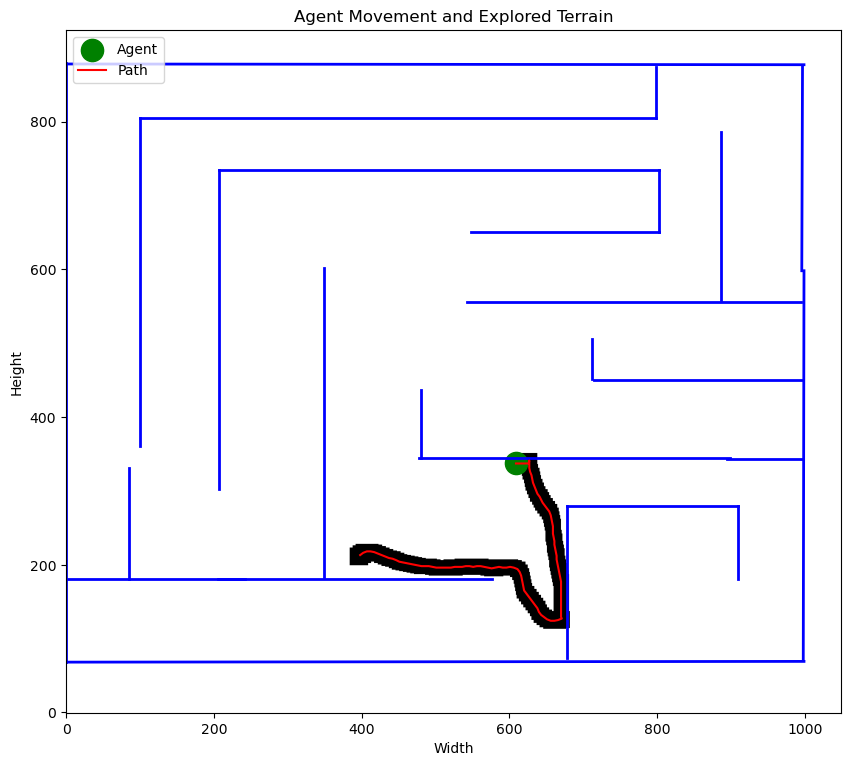

final pos [609. 337.] initial pos [394. 210.]  collisions 0 explored terrain 0.0217375 fitness 0.0217375


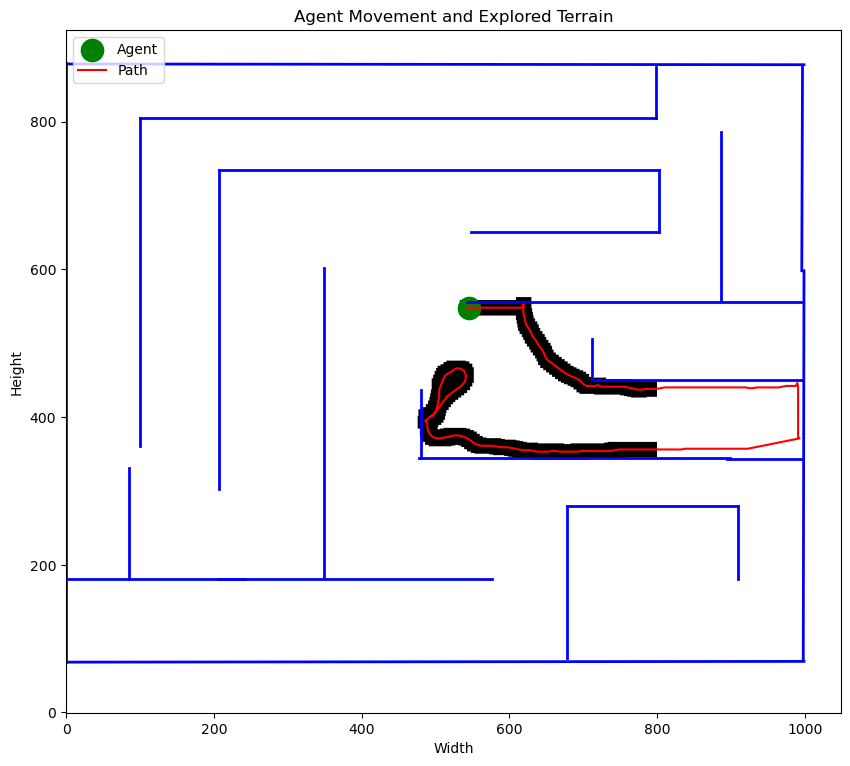

final pos [546. 548.] initial pos [487. 397.]  collisions 0 explored terrain 0.0296546875 fitness 0.0296546875


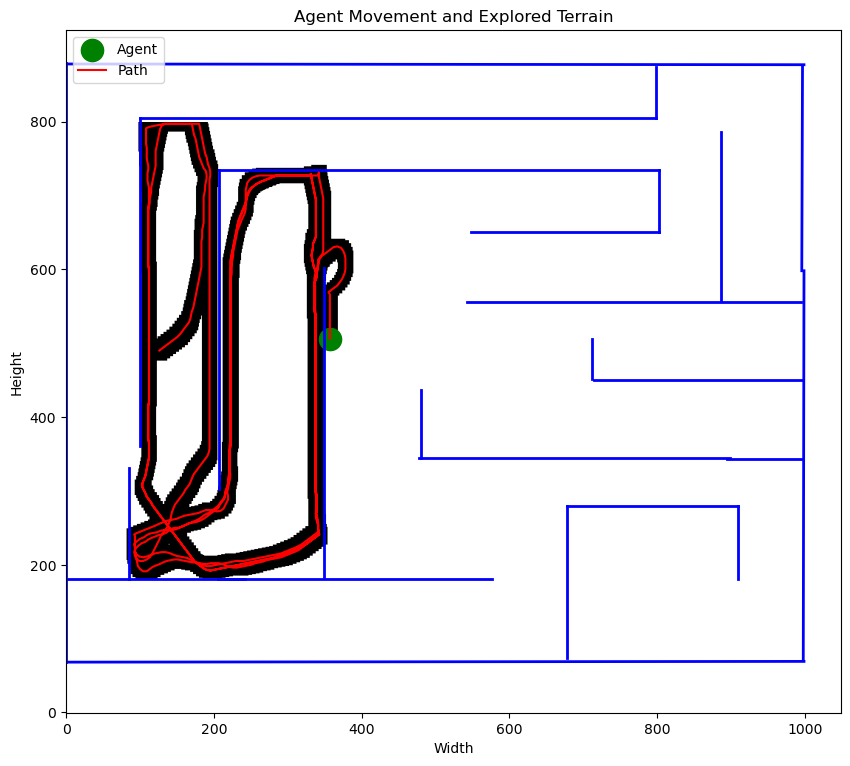

final pos [357. 506.] initial pos [122. 487.]  collisions 0 explored terrain 0.1146765625 fitness 0.1146765625


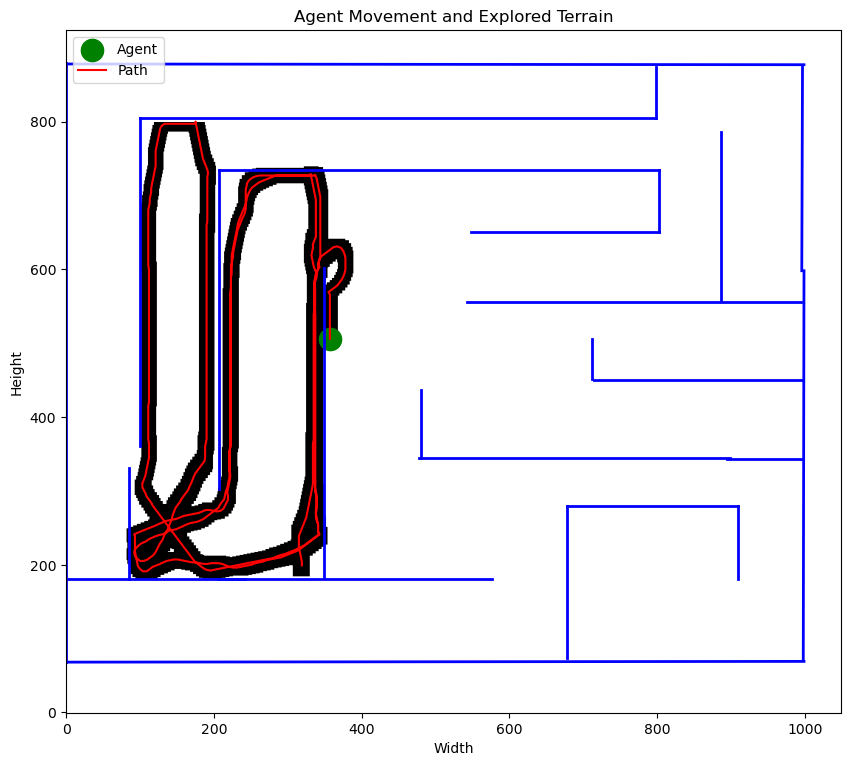

final pos [357. 506.] initial pos [317. 195.]  collisions 0 explored terrain 0.1056828125 fitness 0.1056828125


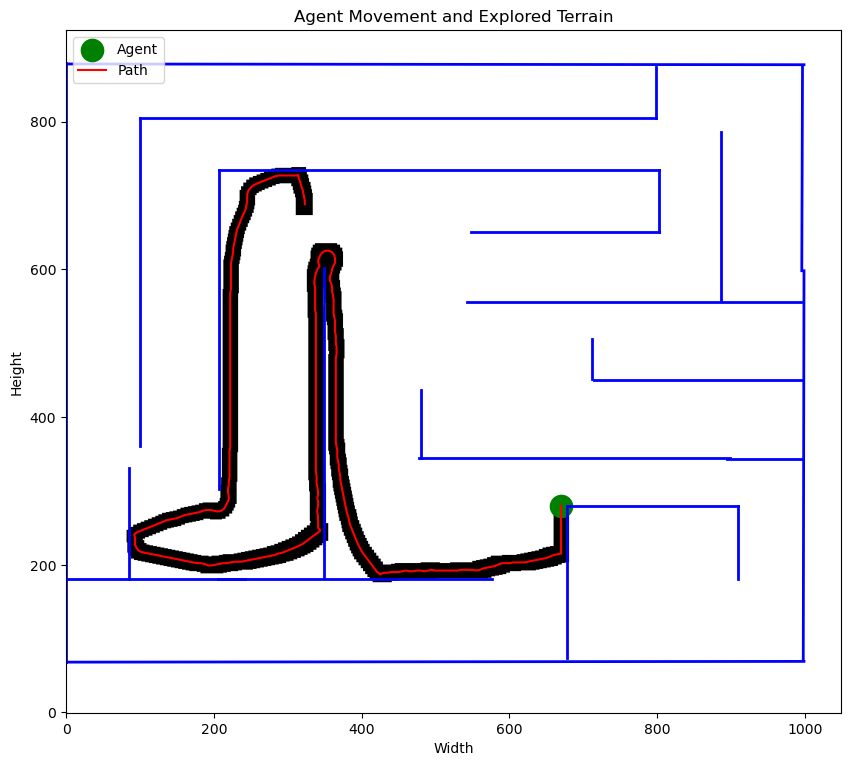

final pos [670. 280.] initial pos [321. 684.]  collisions 0 explored terrain 0.0759890625 fitness 0.0759890625


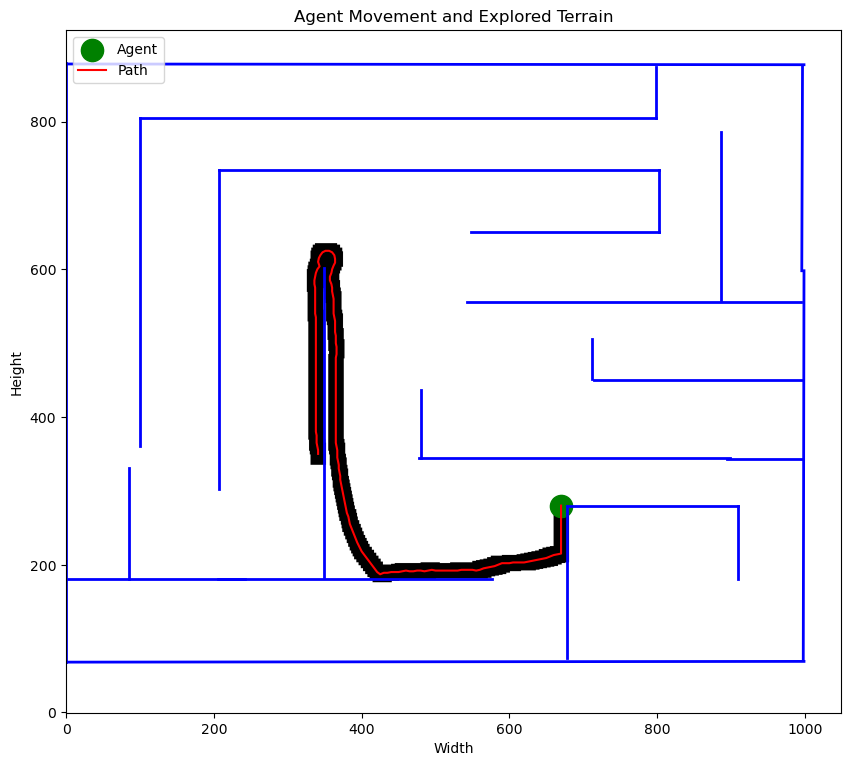

final pos [670. 280.] initial pos [341. 346.]  collisions 0 explored terrain 0.0382796875 fitness 0.0382796875


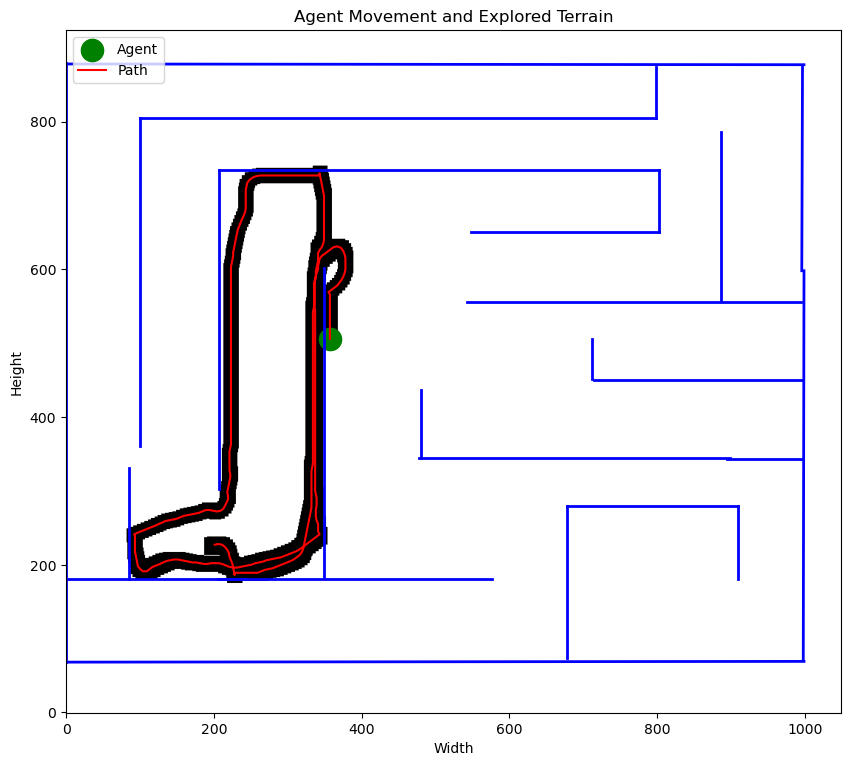

final pos [357. 506.] initial pos [197. 224.]  collisions 0 explored terrain 0.063109375 fitness 0.063109375


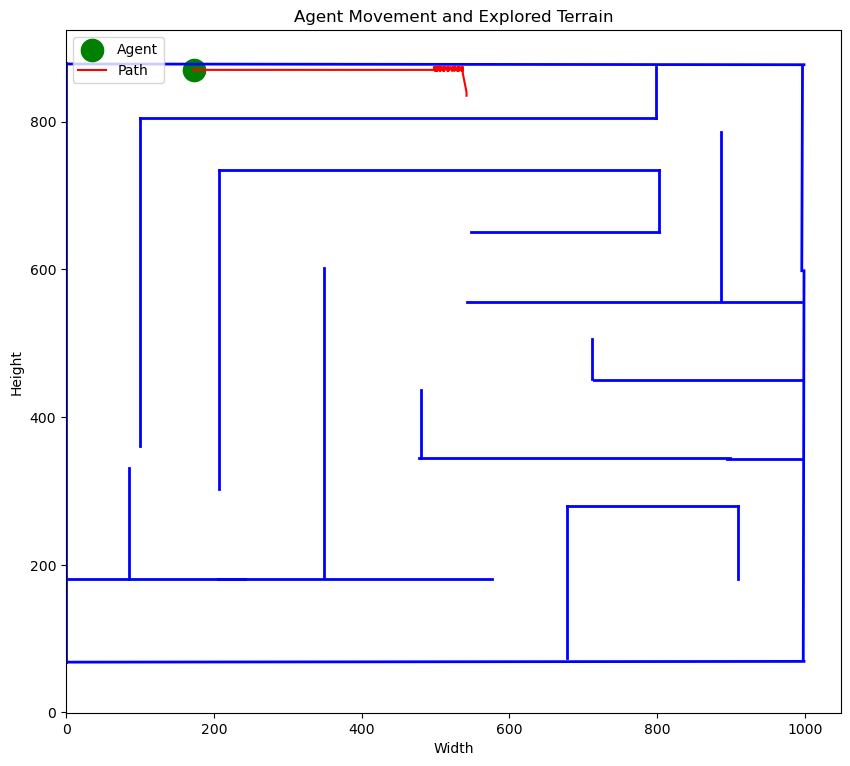

final pos [173. 870.] initial pos [540. 831.]  collisions 0 explored terrain 0.0 fitness 0.0


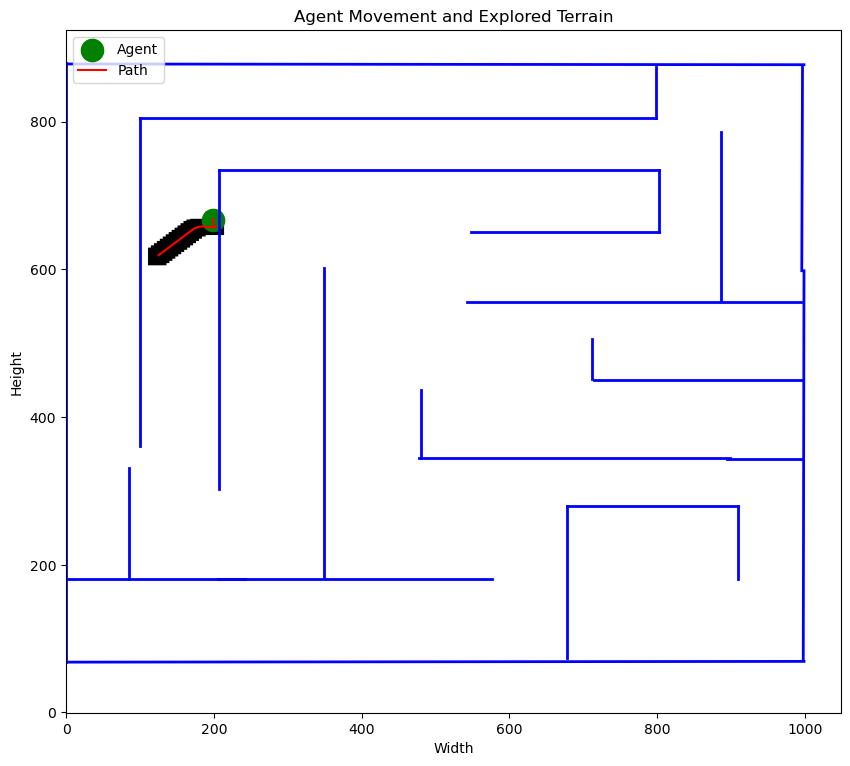

final pos [199. 667.] initial pos [121. 616.]  collisions 0 explored terrain 0.005378125 fitness 0.005378125


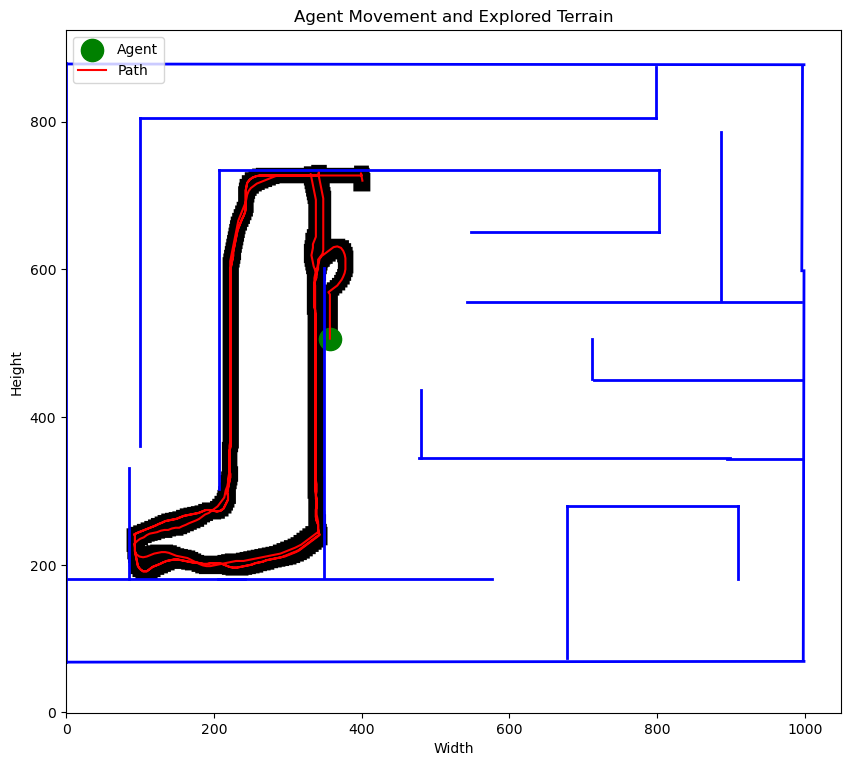

final pos [357. 506.] initial pos [399. 716.]  collisions 0 explored terrain 0.066975 fitness 0.066975


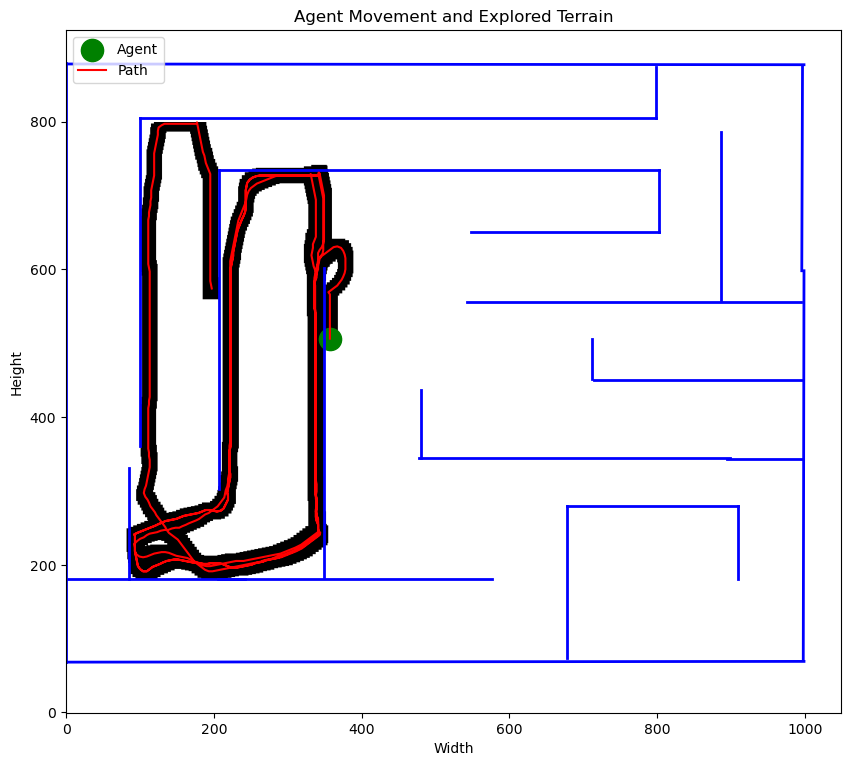

final pos [357. 506.] initial pos [195. 570.]  collisions 0 explored terrain 0.0935359375 fitness 0.0935359375


KeyboardInterrupt: 

In [3]:
for simulation in range(10000):    
    x,y = float(np.random.randint(100, 600)), float(np.random.randint(100, 850))
    env = EnvEvolution(
        EvolvedAgent(x=x, y=y, controller=NN(), n_sensors=12, max_distance=200,size=AGENT_SIZE),
        instants=10000,
        w1=1,
        w2=1,
        w3=0.2,
    )
    env.agent.rotate(pi/4)
    env.agent.controller.load_state_dict(torch.load("./saves/all/gen-5_fit-0.pth"))

    env.load_walls(WALLS_TXT)
    initial_pos = env.agent.pos.copy()
    for step in range(15000):
        # if step == 100 and env.explored_terrain < 0.01:
        #     break
        env.move_agent()

    # if env.explored_terrain < 0.01:
    #     continue
    env.visualize_movement()
    print("final pos", env.agent.pos, "initial pos", initial_pos, " collisions", env.collisions, "explored terrain", env.explored_terrain, "fitness", env.fitness_score())